# Topic modeling using LDA model
The following shema are provided by CHRIS MOODY in his article entitled Presentation of our hybrid lda2with algorithm available [here](https://multithreaded.stitchfix.com/blog/2016/05/27/lda2vec/#topic=38&lambda=1&term=).
- Latent Dirichlet Allocation by Andrew Y. Ng, David M. Blei, Michael I. Jordan (Journal of Machine Learning Research 3; 2003); [PDF](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)  

# <center> ![](https://multithreaded.stitchfix.com/assets/posts/2016-05-27-lda2vec/anim01.gif)
# <center> ![](https://multithreaded.stitchfix.com/assets/posts/2016-05-27-lda2vec/anim02.gif)

In [1]:
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

from pprint import pprint
import glob
import re
import sys 
if not sys.warnoptions: 
    import warnings 
    warnings.simplefilter("ignore")
plt.style.use('ggplot')
#!{sys.executable} -m spacy download en

# Gensim
import gensim, spacy, logging, warnings 
import gensim.corpora as corpora 
from gensim.utils import lemmatize, simple_preprocess 
from gensim.models import CoherenceModel 

# NLTK 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize, word_tokenize 

import string
import torch
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

pd.options.display.max_colwidth = 100 #Display setting to show more characters in column


In [3]:
cord19_df = pd.read_csv('../data_processed/cord19_processed.csv',
                        dtype={'paper_id':str, 'title':str, 'authors':str, 'journal':str, 'abstract':str, 'body_text':str},
                        parse_dates=['publish_time'])
cord19_df.head()

,paper_id,title,authors,journal,publish_time,abstract,body_text
0,aecbc613ebdab36753235197ffb4f35734b5ca63,Clinical and immunologic studies in identical twins discordant for systemic lupus erythematosus,"Brunner, Carolyn M. et al.",The American Journal of Medicine,1973-08-31,"Middle-aged female identical twins, one of whom had systemic lupus erythematosus (SLE), were eva...","The patient (Fo, ) was a 58 year old mentally retarded white woman, born in a rural area of sout..."
1,212e990b378e8d267042753d5f9d4a64ea5e9869,Infectious diarrhea: Pathogenesis and risk factors,"Cantey, J.Robert",The American Journal of Medicine,1985-06-28,"Our understanding of the pathogenesis of infectious, especially bacterial, diarrhea has increase...","Pathogenesis and Risk Factors J. ROBERT CANTEY, M.D. Charleston, South Carolina Our understandin..."
2,bf5d344243153d58be692ceb26f52c08e2bd2d2f,New perspectives on the pathogenesis of rheumatoid arthritis,"Zvaifler, Nathan J.",The American Journal of Medicine,1988-10-14,"In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin...","In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin..."
3,ddd2ecf42ec86ad66072962081e1ce4594431f9c,Management of acute and chronic respiratory tract infections,"Ellner, Jerrold J.",The American Journal of Medicine,1988-09-16,"Pharyngitis, bronchitis, and pneumonia represent the most common respiratory tract infections. W...","Respiratory Tract Infections JERROLD J. ELLNER, M.D. Cleveland, CM Pharyngitis, bronchitis, and ..."
4,a55cb4e724091ced46b5e55b982a14525eea1c7e,Acute bronchitis: Results of U.S. and European trials of antibiotic therapy,"Dere, Willard H.",The American Journal of Medicine,1992-06-22,"Acute bronchitis, an illness frequently encountered by primary-care physicians, is an inflammati...","A cute bronchitis, an illness frequently encountered by primary-care physicians [1] , is an infl..."


In [4]:
# Stop words and extension words
english_stopwords = stopwords.words('english') 
english_stopwords.extend(['_url_','_mention_','_hashtag_','figure','unmanned',
                          'also','use','say','subject','edu','would','say','know',
                          'good','go','get','done','try','many','nice','thank','think',
                          'see','rather','easy','easily','lot','lack','make','want','seem',
                          'run','need','even','right','line','even','also','may','take','come',
                          'year','time','hour','first','last','second','high','new','low'])

# Replace contractions with their longer forms
contraction_mapping = {"u.s.":"america", "u.s":"america", "usa":"america", "u.k.":"england", "u.k":"england", "e-mail":"email",
                       "can't": "cannot", "'cause": "because", "could've": "could have","he'd": "he would","he'll": "he will", 
                       "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", 
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't've": "might not have", "must've": "must have",
                       "mustn't've": "must not have", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have",
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                       "they're": "they are", "they've": "they have", "to've": "to have", "we'd":"we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're":"we are", "we've":"we have",
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've":"where have", "who'll":"who will", "who'll've":"who will have", "who's":"who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                       "would've": "would have", "wouldn't've":"would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                       "y'all've": "you all have","you'd've": "you would have"}

# URL, MENTION, HASHTAG 
giant_url_regex= 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
mention_regex  = '@[\w\-]+'
hashtag_regex  = '#[\w\-]+'
space_pattern  = '\s+'

In [5]:
def process_to_words(papers):
    
    for texts in papers:
        # Deal with URL, MENTION, HASHTAG
        texts = re.sub(space_pattern, ' ', texts)
        texts = re.sub(giant_url_regex, '_URL_', texts)
        texts = re.sub(mention_regex, '_MENTION_', texts)
        texts = re.sub(hashtag_regex, '_HASHTAG_', texts)

        # Special_character
        texts = re.sub(r"\/"," ", texts)
        texts = re.sub(r"\^"," ^ ", texts)
        texts = re.sub(r"\+"," + ", texts)
        texts = re.sub(r"\-"," - ", texts)
        texts = re.sub(r"\="," = ", texts)
        texts = re.sub(r"\/"," ", texts)
        texts = re.sub(r"\^"," ^ ", texts)
        texts = re.sub(r"\+"," + ", texts)
        texts = re.sub(r"\-"," - ", texts)
        texts = re.sub(r"\="," = ", texts)

        # contraction and punctuation
        texts = texts.lower()
        texts = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in nltk.word_tokenize(texts)])
        texts = texts.replace(' .', '.').replace('( ', '(').replace(' )', ')')
        texts = texts.translate(str.maketrans('', '', string.punctuation))
        
        texts = gensim.utils.simple_preprocess(str(texts), deacc=True)
        yield(texts)

In [6]:
%%time 
# Convert to list
words_list = list(process_to_words(cord19_df.abstract))

CPU times: user 58.6 s, sys: 435 ms, total: 59 s
Wall time: 59.5 s


# Creating Bigram and Trigram Models

The two most important arguments to Phrases are:  
- `min_count` ignore all words and bigrams with total collected count lower than this value.  
- `threshold` represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words `a` followed by `b` is accepted if the score of the phrase is greater than threshold. 

In [7]:
%%time
# Build the bigram and trigram models
bigram  = gensim.models.Phrases(words_list, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words_list], threshold=70)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod  = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 1min, sys: 422 ms, total: 1min
Wall time: 1min 1s


In [8]:
def tokenize_Ngram(texts,
                  stop_words=english_stopwords,
                  allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """
    Remove Stopwords, Form Bigrams, Trigrams and Lemmatization
    """
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words 
              and len(word)>2 and word.isalpha()] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts] 
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    nlp = spacy.load('en', disable=['parser', 'ner'])
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words and len(word)>2] for doc in texts_out]    
    return texts_out


In [9]:
%%time
data_ready = tokenize_Ngram(words_list)

CPU times: user 3min 8s, sys: 3.75 s, total: 3min 12s
Wall time: 3min 13s


In [11]:
print(trigram_mod[bigram_mod[data_ready[0][:100]]])

['middle_aged', 'female', 'identical', 'twin', 'evaluate', 'immunologic', 'reactivity', 'previous', 'antigenic', 'challenge', 'include', 'primary', 'immunization', 'foreign', 'antigen', 'keyhole', 'limpet', 'hemocyanin', 'klh', 'woman', 'live', 'together', 'receive', 'drug', 'study', 'twin', 'demonstrate', 'comparable', 'humoral', 'antibody', 'response', 'klh', 'well', 'similar', 'viral', 'antibody_titer', 'however', 'twin', 'sle', 'anergic', 'common', 'antigen', 'streptokinase', 'streptodornase', 'trichophyton', 'candida', 'furthermore', 'delay', 'klh', 'develop', 'immunization', 'observed', 'discrepancy', 'humoral', 'cellular', 'immunity', 'genetically', 'similar', 'significant', 'pathogenesis', 'sle']


## Building the Topic Model with 4 topics

In [12]:
%%time
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                            alpha='symmetric', num_topics=4, 
                                            random_state=42, chunksize=100, 
                                            passes=5, iterations=1000, 
                                            per_word_topics=True)

CPU times: user 1min 22s, sys: 2.38 s, total: 1min 24s
Wall time: 1min 21s


In [13]:
coherencemodel = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v').get_coherence()
coherencemodel

0.48018214651548036

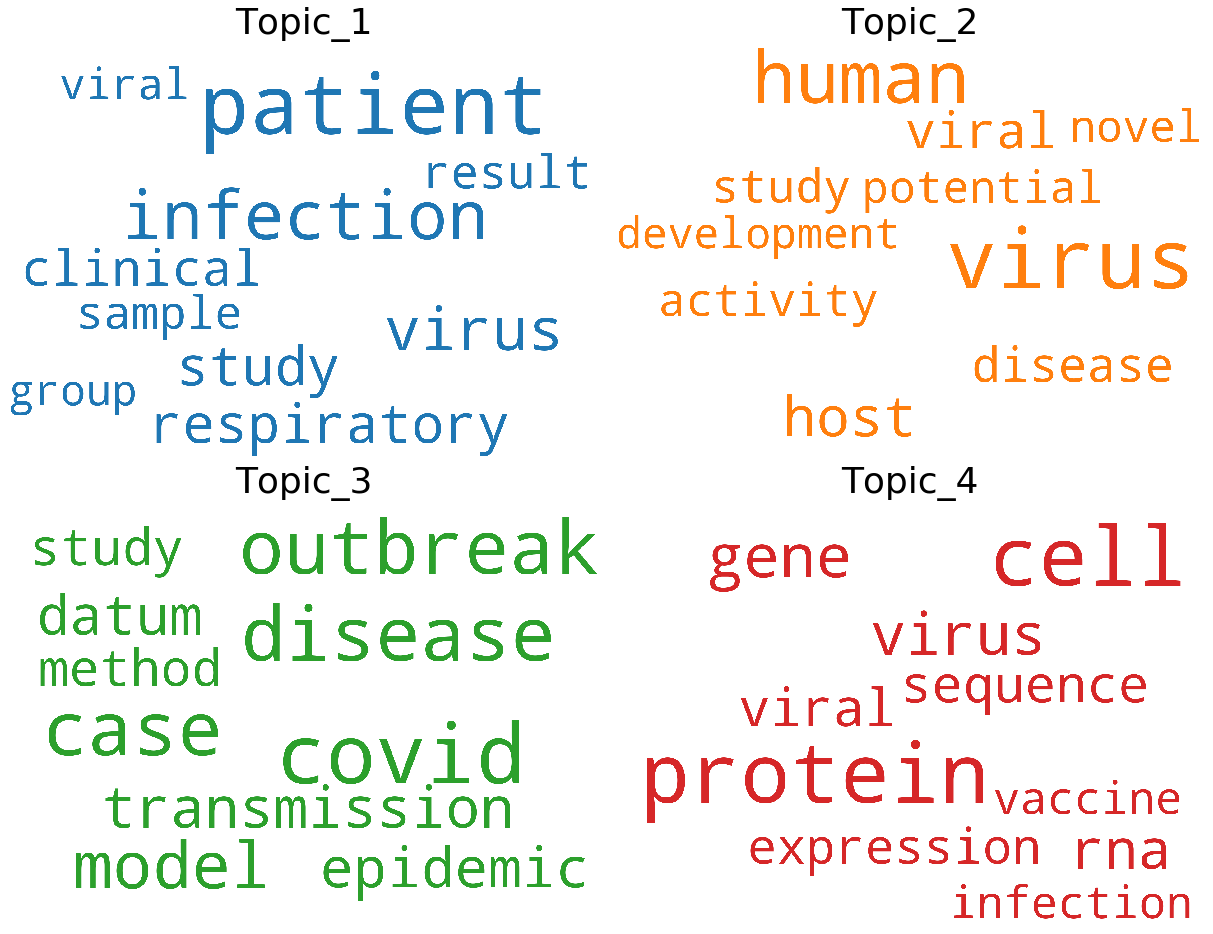

In [14]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=english_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,2, figsize=(17,13), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic_' + str(i+1), fontdict=dict(size=36))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [15]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
df.sort_values('importance', ascending=False, inplace=True)
print(df.shape)
df.head()

(40, 4)


,word,topic_id,importance,word_count
30,protein,3,0.035619,18506
31,cell,3,0.035298,23985
0,patient,0,0.033426,16574
10,virus,1,0.022172,40746
1,infection,0,0.021251,27832


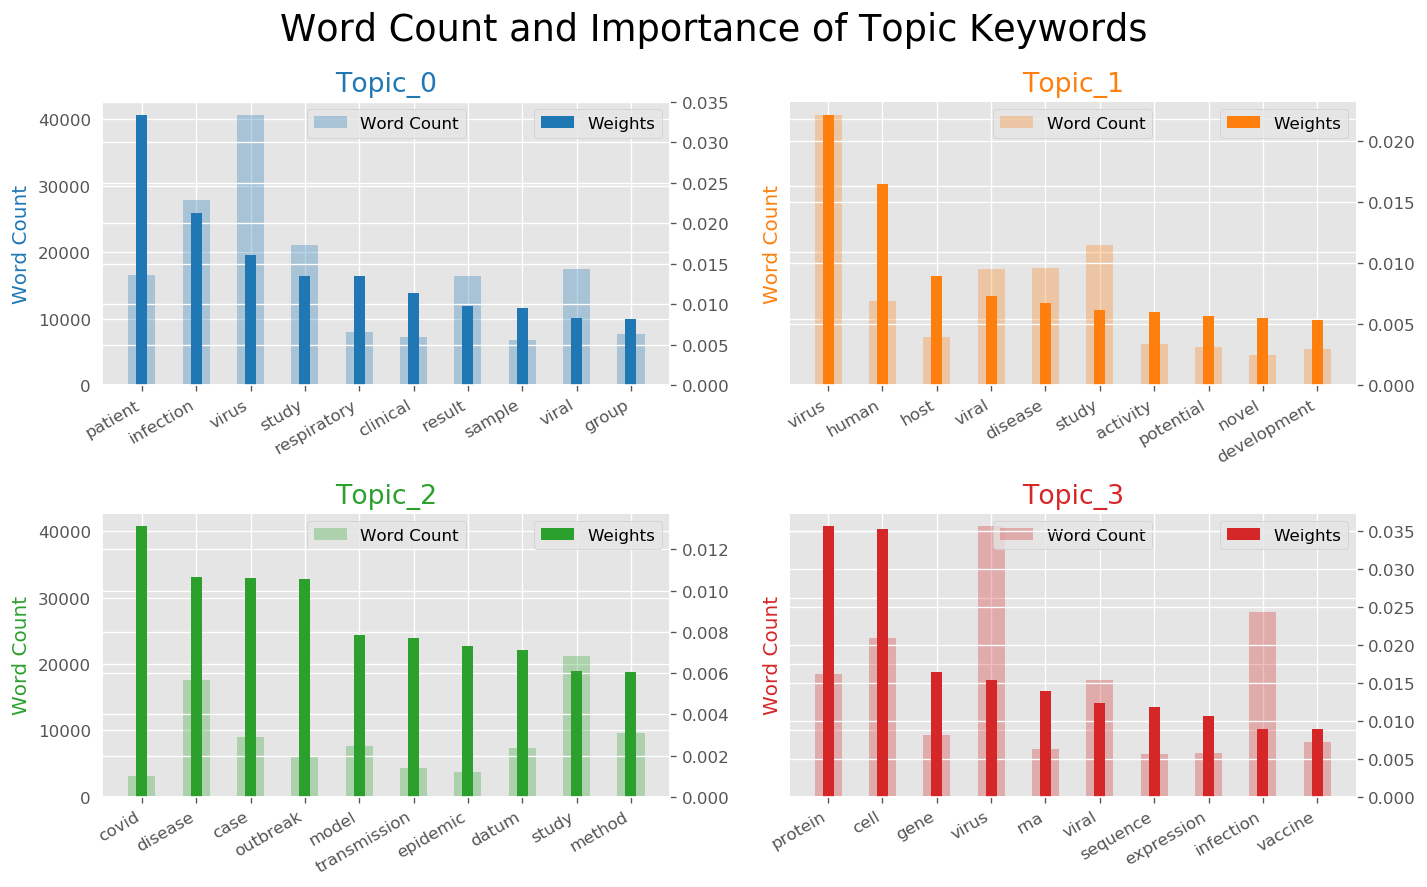

In [16]:
# Plot Word Count and Weights of Topic Keywords 
fig, axes = plt.subplots(2, 2, figsize=(12,7), sharey=True, dpi=120)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.040); ax.set_ylim(0, 40000)
    ax.set_title('Topic_' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [17]:
doc_lda = lda_model[corpus]
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=list(cord19_df.abstract.values)):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list 
        row = sorted(row, key=lambda x: (x[1]), reverse=True) 
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df) 


In [18]:
%%time

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['doc_id', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

df_dominant_topic.sort_values(by='topic_perc_contrib',  ascending=False, inplace=True)
df_dominant_topic.head(5)

CPU times: user 2min 23s, sys: 2.88 s, total: 2min 26s
Wall time: 2min 27s


,doc_id,dominant_topic,topic_perc_contrib,keywords,text
9710,9710,2.0,0.9957,"covid, disease, case, outbreak, model, transmission, epidemic, datum, study, method","[objective, assess, private, hospital, development, china, global, perspective, method, search, ..."
16333,16333,0.0,0.9947,"patient, infection, virus, study, respiratory, clinical, result, sample, viral, group","[background, unclarified, viral, detection, genotype, relate, child, hmpv, infection, lrti, clin..."
23080,23080,2.0,0.9947,"covid, disease, case, outbreak, model, transmission, epidemic, datum, study, method","[unprecedented, measure, adopt, control, rapid, spread, ongoing, covid, epidemic, china, people,..."
25635,25635,2.0,0.9946,"covid, disease, case, outbreak, model, transmission, epidemic, datum, study, method","[early, phase, covid, pandemic, chiefly, report, city, wuhan, case, export, location, largely, p..."
9867,9867,2.0,0.9944,"covid, disease, case, outbreak, model, transmission, epidemic, datum, study, method","[background, objective, study, explore, perception, local, sar, extranet, potential, support, fu..."


In [19]:
print('The percentage of documents that dominated the topic has less than 80% contribution is: {}%'.format(
      round(len(df_dominant_topic.loc[df_dominant_topic.topic_perc_contrib<=0.50])/len(df_dominant_topic)*100,2)))

The percentage of documents that dominated the topic has less than 80% contribution is: 25.27%


In [20]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['perc_contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index 
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format 
sent_topics_sorteddf_mallet.columns = ['no_topic', "topic_perc_contrib", "keywords", "representative text"]

# Show 
sent_topics_sorteddf_mallet

,no_topic,topic_perc_contrib,keywords,representative text
0,0.0,0.9947,"patient, infection, virus, study, respiratory, clinical, result, sample, viral, group","[background, unclarified, viral, detection, genotype, relate, child, hmpv, infection, lrti, clin..."
1,1.0,0.9856,"virus, human, host, viral, disease, study, activity, potential, novel, development","[rhubarb, rheum, emodi, family, polygonaceae, traditionally, diuretic, liver, stimulant, purgati..."
2,2.0,0.9957,"covid, disease, case, outbreak, model, transmission, epidemic, datum, study, method","[objective, assess, private, hospital, development, china, global, perspective, method, search, ..."
3,3.0,0.9475,"protein, cell, gene, virus, rna, viral, sequence, expression, infection, vaccine","[system, express, amino_terminal, half, murine, coronavirus, jhmv, peplomer, glycoprotein, insec..."


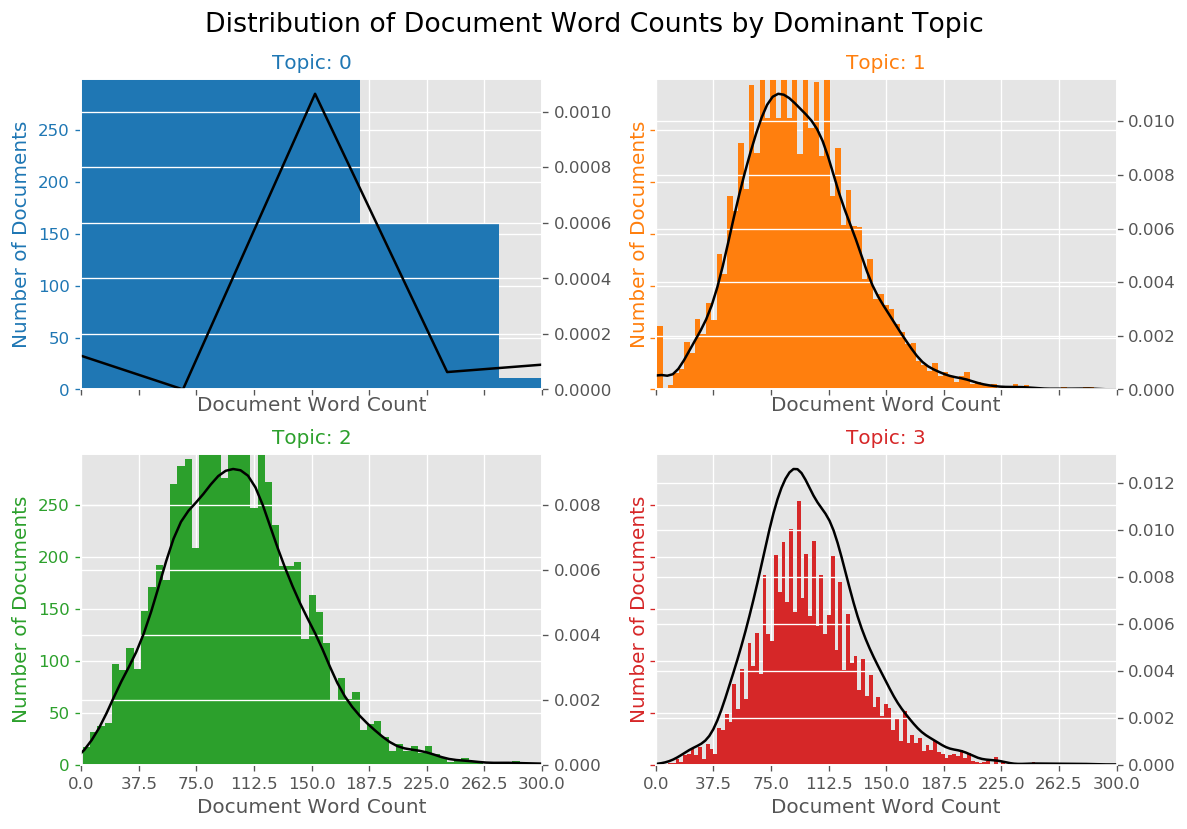

In [21]:
fig, axes = plt.subplots(2,2, figsize=(10,7), dpi=120, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.dominant_topic == i,:]
    doc_lens = [len(d) for d in df_dominant_topic_sub.text]
    ax.hist(doc_lens, bins = 120, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 300), ylim=(0, max(doc_lens)), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=12, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,300,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=16)
plt.show()

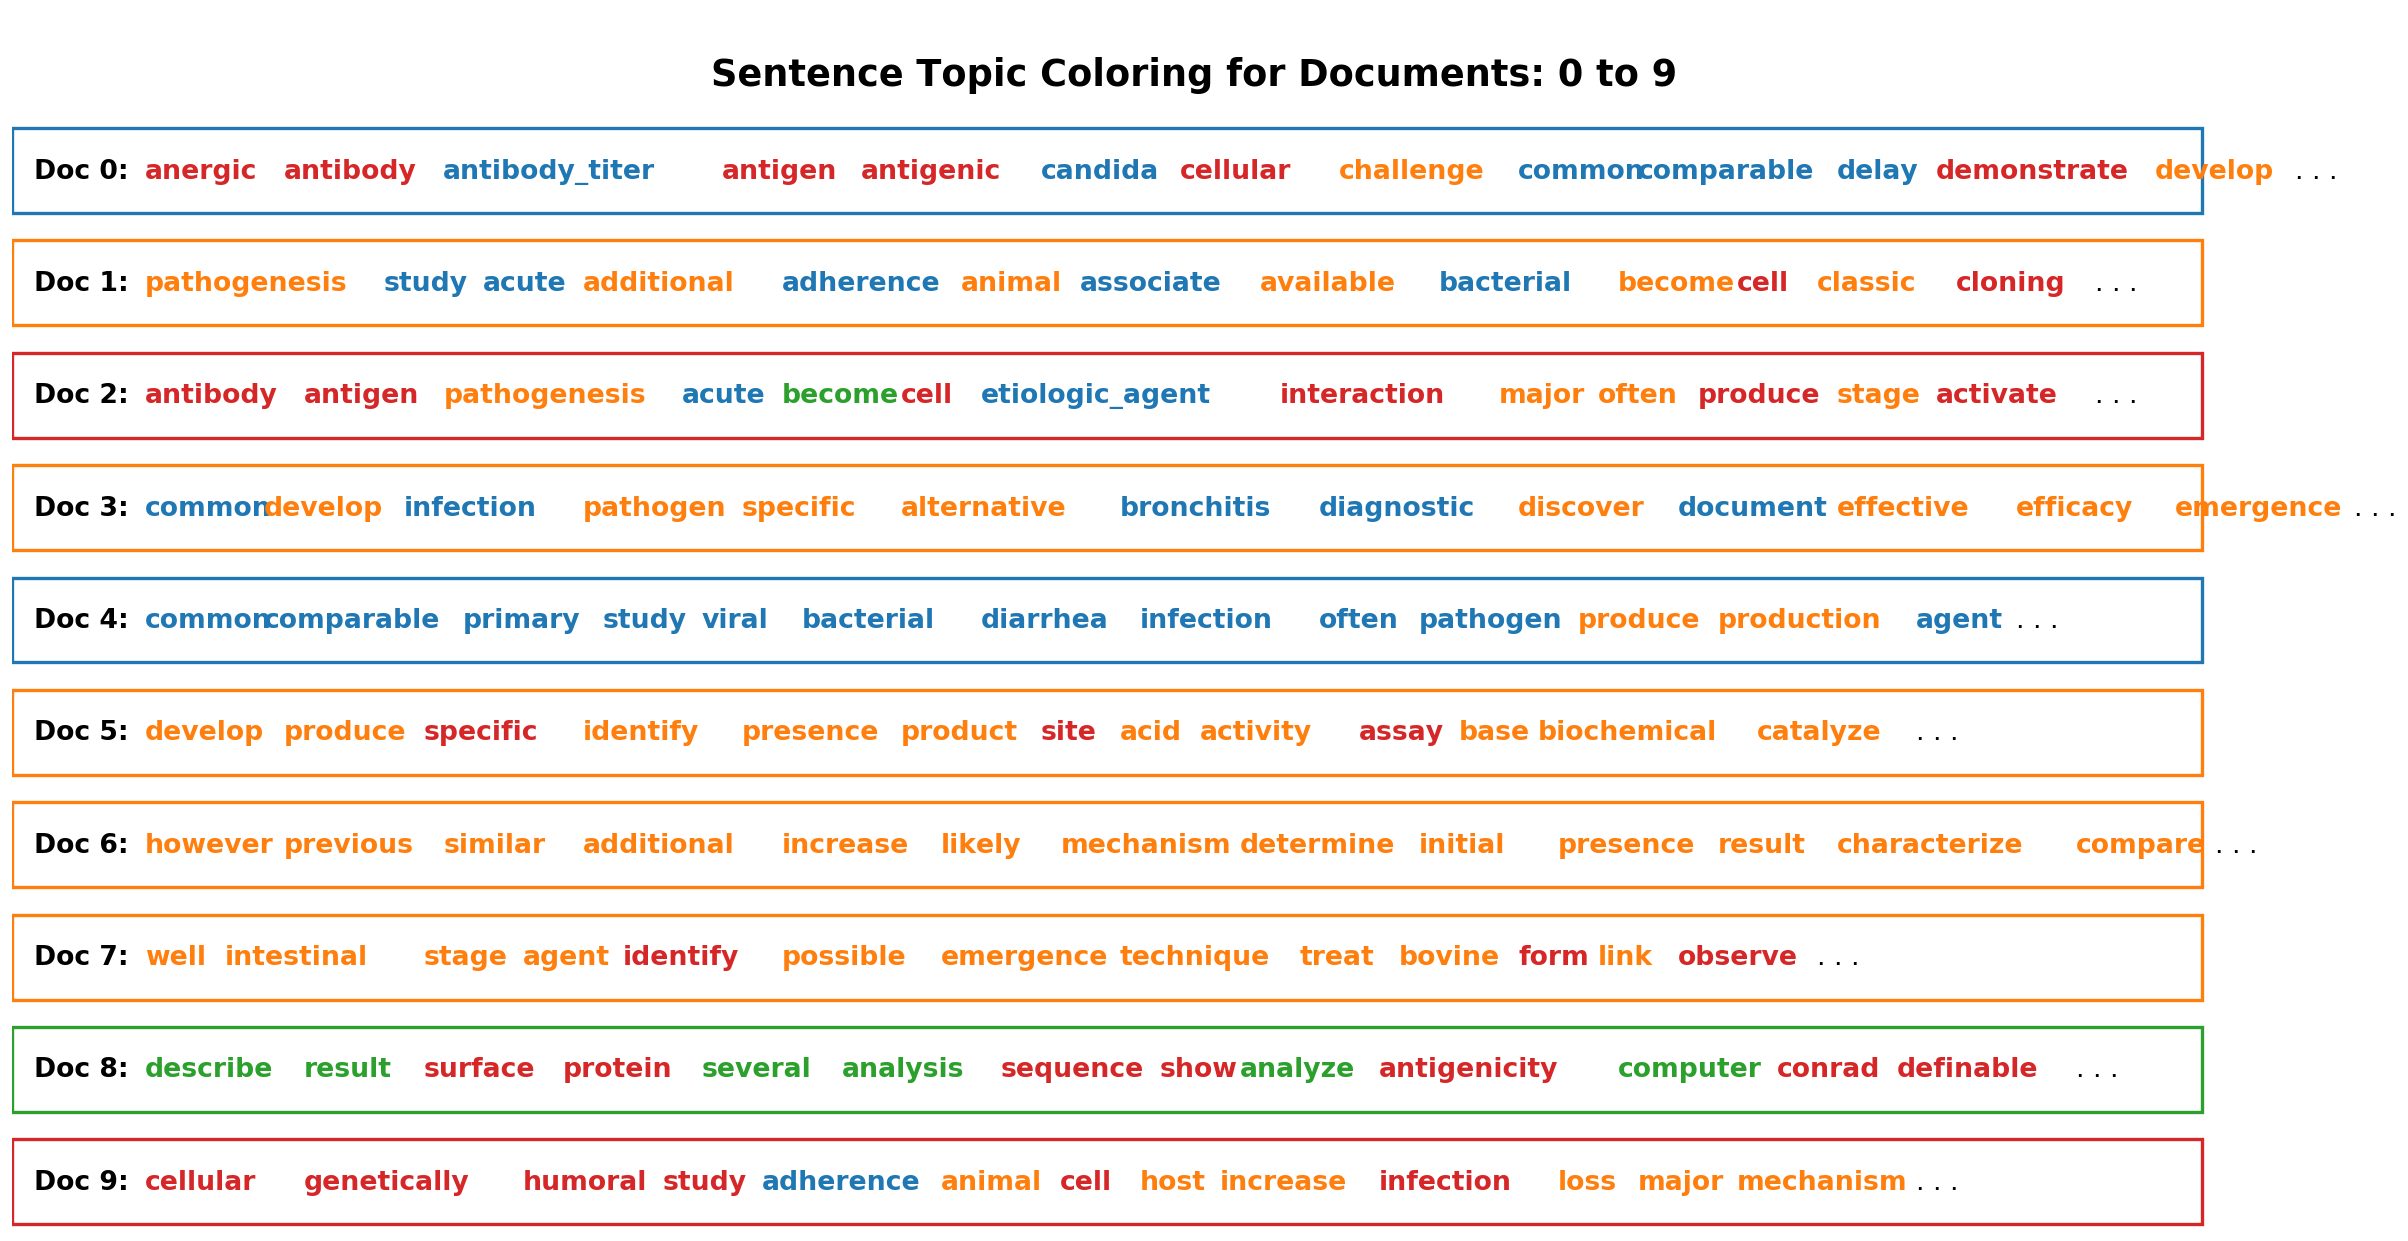

In [22]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=11):
    
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=120)       
    axes[0].axis('off')
    
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics] 
            
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)
            
            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))
            
            word_pos = 0.06 
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 13:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: '+str(start)+' to '+str(end-2),
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [23]:
%%time
import pyLDAvis.gensim
pyLDAvis.enable_notebook(local=False)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis 

CPU times: user 44.8 s, sys: 834 ms, total: 45.7 s
Wall time: 48.9 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.077300  0.190261       1        1  28.396696
2      0.165549  0.040515       2        1  26.958006
0      0.078786 -0.238849       3        1  23.681091
3     -0.321635  0.008072       4        1  20.964201, topic_info=            Term          Freq         Total Category  logprob  loglift
292      protein  20821.000000  20821.000000  Default  30.0000  30.0000
60          cell  21963.000000  21963.000000  Default  29.0000  29.0000
246      patient  23472.000000  23472.000000  Default  28.0000  28.0000
78          gene   9616.000000   9616.000000  Default  27.0000  27.0000
13696      covid   9865.000000   9865.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
84     infection   5224.325684  26875.216797   Topic4  -4.7175  -0.0755
8194         sar   3561.004150   8796.093750   Topic4  -5.1008   0.6581
167       result   4261.661133  16224.059570   Topic4  -4.9212   0.2255
300      suggest   3088.783203   6692.031738   Topic4  -5.2431   0.7892
45         study   3600.880371  21943.472656   Topic4  -5.0897  -0.2449

[272 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
8873      1  0.999529         ace
433       4  0.999687  activation
257       1  0.856945    activity
257       4  0.143005    activity
52        3  0.999875       acute
...     ...       ...         ...
594       1  0.999067        vivo
50        1  0.546260        well
50        2  0.287954        well
50        3  0.119833        well
50        4  0.045980        well

[406 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [27]:
%%time 
import malaya

ModuleNotFoundError: No module named 'tensorflow.contrib'